# RF Regressor, Feature engineering

## Импорт модулей

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
)

from feature_engine.creation import MathFeatures
from itertools import combinations

## Константы

In [2]:
TRAIN_PATH = "../Lesson36/train.csv"
TARGET = "Premium Amount"
RANDOM_STATE = 777
TEST_SIZE = 0.2

## Загрузка данных

In [3]:
df = pd.read_csv(TRAIN_PATH, index_col="id")
df = df.sample(n=10000, random_state=RANDOM_STATE, replace=False)

print("Train DataFrame")
df.head()

Train DataFrame


,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
id,,,,,,,,,,,,,,,,,,,,
1064660,56.0,Male,1324.0,Divorced,4.0,Bachelor's,Self-Employed,NaN,Urban,Premium,NaN,14.0,589.0,2.0,2020-09-21 15:21:39.194829,Good,No,Daily,Apartment,597.0
943409,49.0,Female,38217.0,Single,3.0,Master's,Unemployed,18.793478,Urban,Comprehensive,4.0,4.0,751.0,9.0,2021-10-22 15:21:39.224915,Average,Yes,Monthly,Apartment,1147.0
1187526,21.0,Male,122531.0,Single,3.0,High School,NaN,11.980426,Rural,Comprehensive,0.0,9.0,454.0,4.0,2021-06-10 15:21:39.289099,Good,Yes,Rarely,Apartment,1167.0
558015,35.0,Female,2714.0,Single,2.0,PhD,Self-Employed,18.362567,Urban,Comprehensive,1.0,16.0,478.0,7.0,2021-10-11 15:21:39.134960,Average,Yes,Rarely,Apartment,548.0
496945,18.0,Male,7071.0,Married,3.0,Master's,Unemployed,40.043921,Suburban,Basic,0.0,14.0,473.0,6.0,2023-02-05 15:21:39.154008,Poor,Yes,Weekly,Apartment,1074.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1064660 to 535173
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   9861 non-null   float64
 1   Gender                10000 non-null  object 
 2   Annual Income         9627 non-null   float64
 3   Marital Status        9857 non-null   object 
 4   Number of Dependents  9110 non-null   float64
 5   Education Level       10000 non-null  object 
 6   Occupation            6968 non-null   object 
 7   Health Score          9396 non-null   float64
 8   Location              10000 non-null  object 
 9   Policy Type           10000 non-null  object 
 10  Previous Claims       7007 non-null   float64
 11  Vehicle Age           10000 non-null  float64
 12  Credit Score          8860 non-null   float64
 13  Insurance Duration    10000 non-null  float64
 14  Policy Start Date     10000 non-null  object 
 15  Customer Feedback

## Исследовательский анализ данных

In [5]:
# Удалим колонку с датой
df = df.drop(columns=["Policy Start Date"])

# Выделим числовые и категориальные признаки
numeric_columns = [
    col for col in df.columns if df[col].dtype == "float64" if col != TARGET
]
categoric_columns = [col for col in df.columns if df[col].dtype == "object"]

In [6]:
def numeric_columns_stats(df):
    stats = pd.DataFrame(index=df.columns)
    stats["Доля пропусков"] = df.isnull().mean()
    stats["Минимум"] = df.min().round(2)
    stats["Максимум"] = df.max().round(2)
    stats["Среднее"] = df.mean().round(2)
    stats["Медиана"] = df.median().round(2)
    stats["Дисперсия"] = df.var().round(2)
    stats["Квантиль 0.1"] = df.quantile(0.1).round(2)
    stats["Квантиль 0.9"] = df.quantile(0.9).round(2)
    stats["Квартиль 1"] = df.quantile(0.25).round(2)
    stats["Квартиль 3"] = df.quantile(0.75).round(2)

    return stats


def categoric_columns_stats(df):
    stats = pd.DataFrame(index=df.columns)
    stats["Доля пропусков"] = df.isnull().mean()
    stats["Количество уникальных значений"] = df.nunique()
    stats["Мода"] = df.mode().transpose()

    return stats

In [7]:
# Результаты EDA для числовых признаков
numeric_columns_stats(df[numeric_columns + [TARGET]])

,Доля пропусков,Минимум,Максимум,Среднее,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
Age,0.0139,18.00,64.00,41.28,42.00,1.805200e+02,23.00,60.00,30.00,53.00
Annual Income,0.0373,17.00,149993.00,32507.43,23696.00,1.033610e+09,2594.40,81206.40,7832.50,44628.00
Number of Dependents,0.0890,0.00,4.00,2.02,2.00,1.990000e+00,0.00,4.00,1.00,3.00
Health Score,0.0604,2.26,55.38,25.95,24.87,1.500600e+02,10.26,43.88,16.07,34.98
Previous Claims,0.2993,0.00,8.00,1.01,1.00,9.800000e-01,0.00,2.00,0.00,2.00
Vehicle Age,0.0000,0.00,19.00,9.57,10.00,3.337000e+01,2.00,18.00,5.00,15.00
Credit Score,0.1140,300.00,849.00,592.77,593.00,2.228874e+04,388.00,793.00,468.00,719.00
Insurance Duration,0.0000,1.00,9.00,5.03,5.00,6.790000e+00,1.00,9.00,3.00,7.00
Premium Amount,0.0000,20.00,4986.00,1106.29,871.00,7.511698e+05,148.00,2369.00,518.75,1514.00


In [8]:
# Результаты EDA для категориальных признаков
categoric_columns_stats(df[categoric_columns])

,Доля пропусков,Количество уникальных значений,Мода
Gender,0.0000,2,Female
Marital Status,0.0143,3,Married
Education Level,0.0000,4,PhD
Occupation,0.3032,3,Employed
Location,0.0000,3,Rural
Policy Type,0.0000,3,Premium
Customer Feedback,0.0685,3,Average
Smoking Status,0.0000,2,No
Exercise Frequency,0.0000,4,Weekly
Property Type,0.0000,3,Apartment


Данные содержат пропущенные значения и имеют различный масштаб.

## Подготовка датасета к построению моделей ML

### Распределение целевой переменной

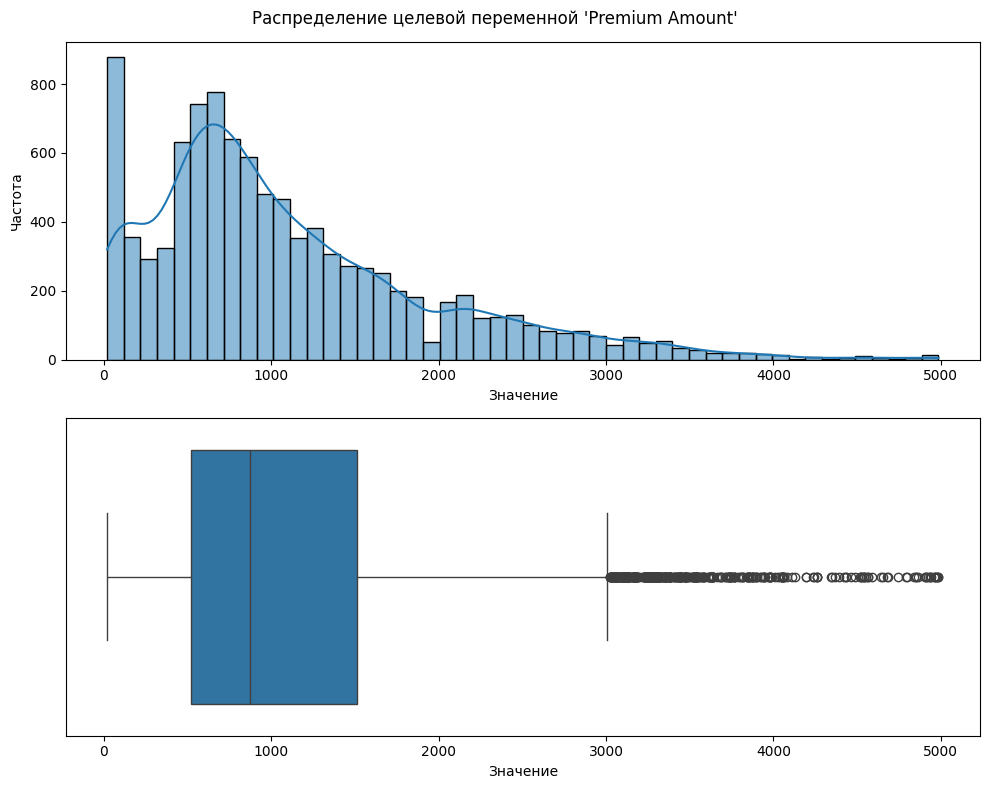

In [9]:
# Визуализация распределения целевой переменной
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

sns.histplot(df[TARGET], bins=50, kde=True, ax=ax[0])
ax[0].set_xlabel("Значение")
ax[0].set_ylabel("Частота")

sns.boxplot(df[TARGET], orient="h", ax=ax[1])
ax[1].set_xlabel("Значение")
ax[1].set_yticks([])

plt.suptitle(f"Распределение целевой переменной '{TARGET}'")
plt.tight_layout()
plt.show()

Распределение целевого признака похоже на распределение Пуассона с тяжелым хвостом, оставим его без изменения.

### Обработка пропусков

Заменим пропуски числовых переменных на значение медианы, а категориальных на значение моды.

In [10]:
# Заполняем числовые переменные
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

# Заполняем категориальные переменные
# Для случая если встретятся 2 значения с одинаковой частотой, берем первое из них x.mode()[0]
df[categoric_columns] = df[categoric_columns].apply(lambda x: x.fillna(x.mode()[0]))

### Обработка выбросов

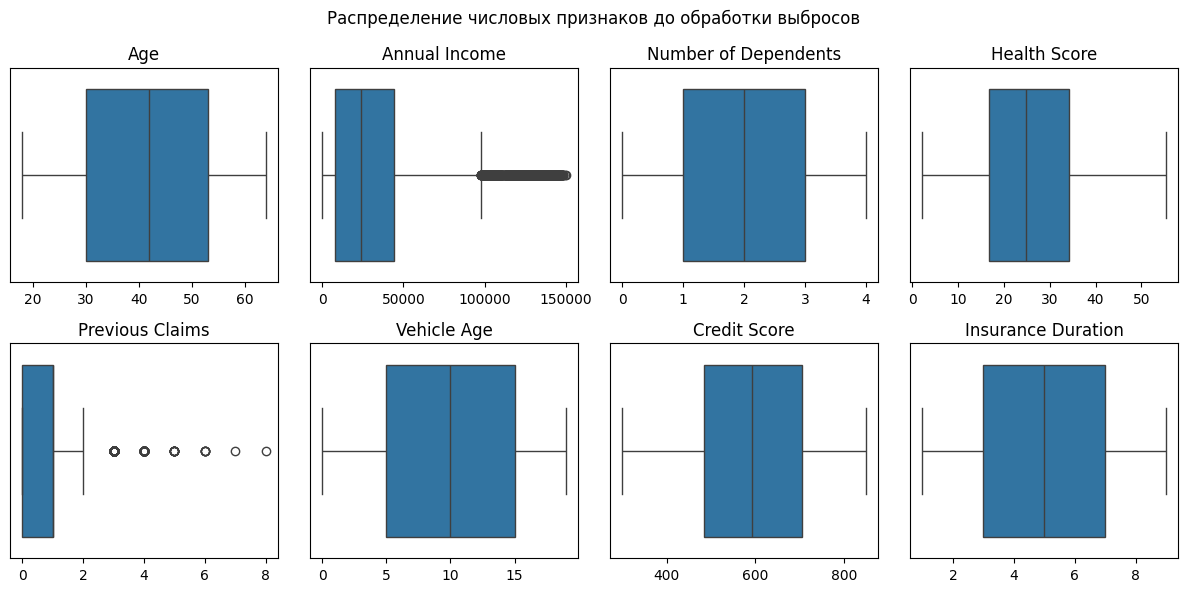

In [11]:
# Отображение распределения числовых признаков до обработки выбросов
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, col in enumerate(numeric_columns):
    row_idx, col_idx = divmod(i, 4)
    sns.boxplot(df[numeric_columns][col], ax=ax[row_idx, col_idx], orient="h")
    ax[row_idx, col_idx].set_title(col)
    ax[row_idx, col_idx].set_xlabel(None)
    ax[row_idx, col_idx].set_yticks([])

plt.suptitle("Распределение числовых признаков до обработки выбросов")
plt.tight_layout()
plt.show()

Больше всего выбросов содержит признак "Annual Income", в нем встречаются как экстримально малые значения (около 17.0) так и очень высокие, выше 100000.0. Заменим низкие значения на величину квантиля 0.1, а высокие на значение межквартильного интервала. Признак "Previus Claims" оставим без изменений, т.к. он дает информацию об особенностях поведения клиентов.

In [12]:
# Функция для обработки выбросов
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = df[col].quantile(0.1)
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df


df = remove_outliers(df, ["Annual Income"])

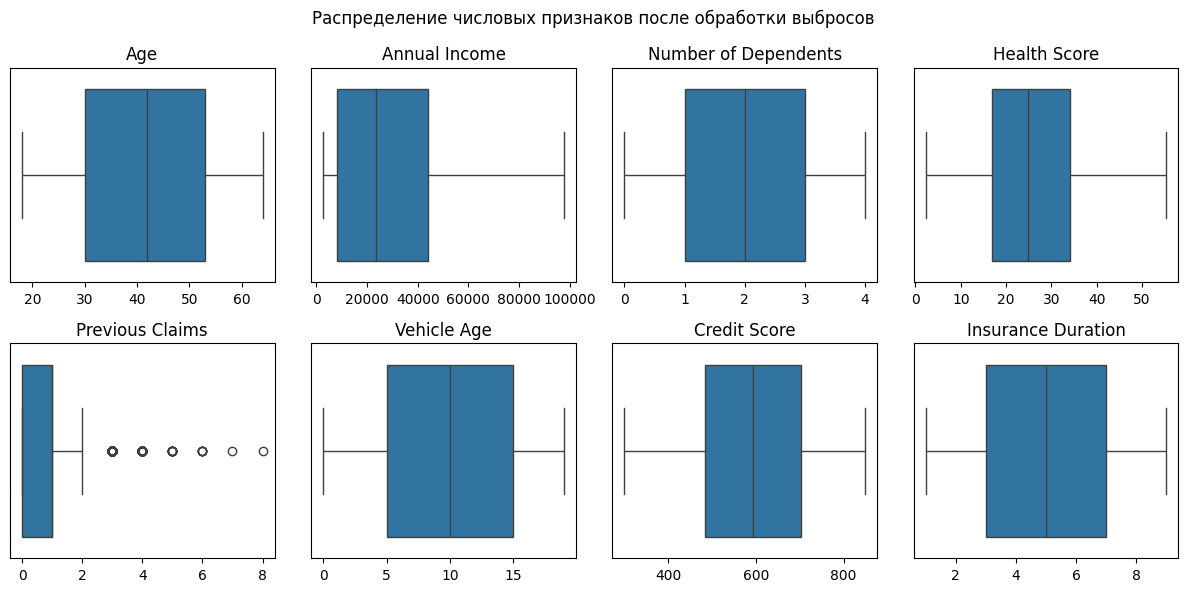

In [13]:
# Отображение распределения числовых признаков после обработки выбросов
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, col in enumerate(numeric_columns):
    row_idx, col_idx = divmod(i, 4)
    sns.boxplot(df[numeric_columns][col], ax=ax[row_idx, col_idx], orient="h")
    ax[row_idx, col_idx].set_title(col)
    ax[row_idx, col_idx].set_xlabel(None)
    ax[row_idx, col_idx].set_yticks([])

plt.suptitle("Распределение числовых признаков после обработки выбросов")
plt.tight_layout()
plt.show()

Выбросы удалены.

EDA после обработки признаков.

In [14]:
# Результаты EDA для числовых признаков
numeric_columns_stats(df[numeric_columns + [TARGET]])

,Доля пропусков,Минимум,Максимум,Среднее,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
Age,0.0,18.00,64.00,41.29,42.00,1.780100e+02,23.00,60.00,30.00,53.0
Annual Income,0.0,2706.20,97639.25,30958.23,23696.00,7.658936e+08,2706.92,79283.80,8075.50,43901.0
Number of Dependents,0.0,0.00,4.00,2.02,2.00,1.810000e+00,0.00,4.00,1.00,3.0
Health Score,0.0,2.26,55.38,25.89,24.87,1.410600e+02,10.64,43.38,16.81,34.2
Previous Claims,0.0,0.00,8.00,1.01,1.00,6.900000e-01,0.00,2.00,0.00,1.0
Vehicle Age,0.0,0.00,19.00,9.57,10.00,3.337000e+01,2.00,18.00,5.00,15.0
Credit Score,0.0,300.00,849.00,592.80,593.00,1.974757e+04,394.00,787.00,484.00,704.0
Insurance Duration,0.0,1.00,9.00,5.03,5.00,6.790000e+00,1.00,9.00,3.00,7.0
Premium Amount,0.0,20.00,4986.00,1106.29,871.00,7.511698e+05,148.00,2369.00,518.75,1514.0


In [15]:
# Результаты EDA для категориальных признаков
categoric_columns_stats(df[categoric_columns])

,Доля пропусков,Количество уникальных значений,Мода
Gender,0.0,2,Female
Marital Status,0.0,3,Married
Education Level,0.0,4,PhD
Occupation,0.0,3,Employed
Location,0.0,3,Rural
Policy Type,0.0,3,Premium
Customer Feedback,0.0,3,Average
Smoking Status,0.0,2,No
Exercise Frequency,0.0,4,Weekly
Property Type,0.0,3,Apartment


### Кодирование категориальных переменных

In [16]:
# Кодируем методом OneHotEncoding
df = pd.get_dummies(df, columns=categoric_columns, drop_first=True, dtype=int)

df.head()

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Gender_Male,...,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
id,,,,,,,,,,,,,,,,,,,,,
1064660,56.0,2706.20,4.0,24.868785,1.0,14.0,589.0,2.0,597.0,1,...,0,1,1,0,0,0,0,0,0,0
943409,49.0,38217.00,3.0,18.793478,4.0,4.0,751.0,9.0,1147.0,0,...,1,0,0,0,1,1,0,0,0,0
1187526,21.0,97639.25,3.0,11.980426,0.0,9.0,454.0,4.0,1167.0,1,...,1,0,1,0,1,0,1,0,0,0
558015,35.0,2714.00,2.0,18.362567,1.0,16.0,478.0,7.0,548.0,0,...,1,0,0,0,1,0,1,0,0,0
496945,18.0,7071.00,3.0,40.043921,0.0,14.0,473.0,6.0,1074.0,1,...,0,0,0,1,1,0,0,1,0,0


### Анализ корреляций

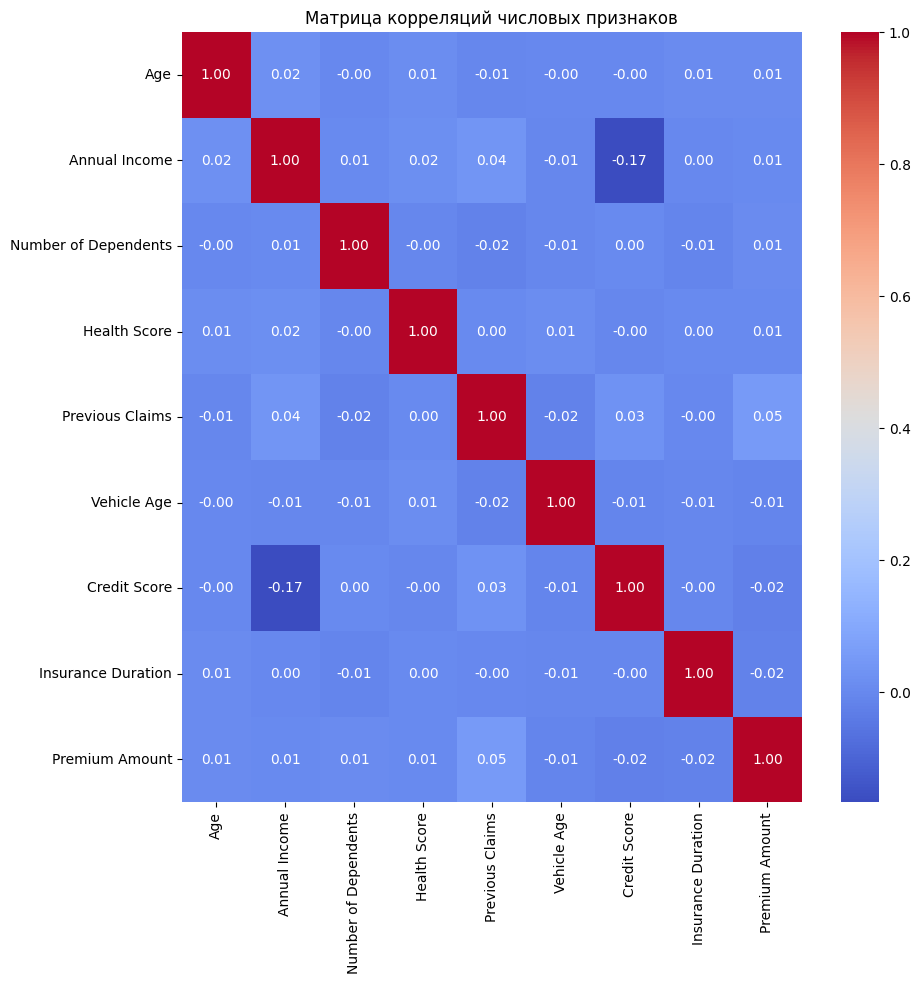

In [17]:
# Матрица корреляций
plt.figure(figsize=(10, 10))
correlation_matrix = df[numeric_columns + [TARGET]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляций числовых признаков")
plt.show()

Заметные корреляции отсутствуют.

## Разделение данных

In [18]:
# Признаки без нормализации
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"X_train.shape={X_train.shape}, y_train.shape={y_train.shape}")
print(f"X_test.shape={X_test.shape}, y_test.shape={y_test.shape}")

X_train.shape=(8000, 28), y_train.shape=(8000,)
X_test.shape=(2000, 28), y_test.shape=(2000,)


## Обучение модели

In [19]:
rfr = RandomForestRegressor(random_state=RANDOM_STATE)
rfr.fit(X_train, y_train)

y_pred_rfr = rfr.predict(X_test)

## Оценка качества

In [20]:
def get_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {"mae": mae, "mse": mse, "rmse": rmse, "r2_score": r2}


# Сравнительная таблица качества моделей
quality_comparison = pd.DataFrame(
    {
        "Metrics": [*get_metrics(y_test, y_pred_rfr).keys()],
        "RandomForestRegressor (init features)": [
            *map(
                lambda x: round(x, 2),
                get_metrics(y_test, y_pred_rfr).values(),
            )
        ],
    }
)

quality_comparison

,Metrics,RandomForestRegressor (init features)
0,mae,673.03
1,mse,733681.52
2,rmse,856.55
3,r2_score,-0.01


Модель обладает средним качеством работы.

## Генерация признаков

In [21]:
# Создание новых признаков через математические комбинации
df_fe = df.copy()
features_combinations = [*combinations(numeric_columns, 2)]
features_combinations += [*combinations(numeric_columns, 3)]

for comb in features_combinations:
    math_comb = MathFeatures(variables=list(comb), func="prod")
    df_fe = math_comb.fit_transform(df_fe)

df_fe.head()

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Gender_Male,...,prod_Health Score_Previous Claims_Vehicle Age,prod_Health Score_Previous Claims_Credit Score,prod_Health Score_Previous Claims_Insurance Duration,prod_Health Score_Vehicle Age_Credit Score,prod_Health Score_Vehicle Age_Insurance Duration,prod_Health Score_Credit Score_Insurance Duration,prod_Previous Claims_Vehicle Age_Credit Score,prod_Previous Claims_Vehicle Age_Insurance Duration,prod_Previous Claims_Credit Score_Insurance Duration,prod_Vehicle Age_Credit Score_Insurance Duration
id,,,,,,,,,,,,,,,,,,,,,
1064660,56.0,2706.20,4.0,24.868785,1.0,14.0,589.0,2.0,597.0,1,...,348.162988,14647.714291,49.73757,205068.000079,696.325976,29295.428583,8246.0,28.0,1178.0,16492.0
943409,49.0,38217.00,3.0,18.793478,4.0,4.0,751.0,9.0,1147.0,0,...,300.695644,56455.607215,676.56520,56455.607215,676.565200,127025.116234,12016.0,144.0,27036.0,27036.0
1187526,21.0,97639.25,3.0,11.980426,0.0,9.0,454.0,4.0,1167.0,1,...,0.000000,0.000000,0.00000,48952.021676,431.295345,21756.454078,0.0,0.0,0.0,16344.0
558015,35.0,2714.00,2.0,18.362567,1.0,16.0,478.0,7.0,548.0,0,...,293.801075,8777.307118,128.53797,140436.913886,2056.607526,61441.149825,7648.0,112.0,3346.0,53536.0
496945,18.0,7071.00,3.0,40.043921,0.0,14.0,473.0,6.0,1074.0,1,...,0.000000,0.000000,0.00000,265170.846855,3363.689389,113644.648652,0.0,0.0,0.0,39732.0


In [22]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1064660 to 535173
Columns: 113 entries, Age to prod_Vehicle Age_Credit Score_Insurance Duration
dtypes: float64(93), int32(20)
memory usage: 7.9 MB


Количество признаков увеличилось до 113.

In [23]:
# Сгенерированные признаки
generated_columns = df_fe.columns.difference(df.columns)
generated_columns

Index(['prod_Age_Annual Income', 'prod_Age_Annual Income_Credit Score',
       'prod_Age_Annual Income_Health Score',
       'prod_Age_Annual Income_Insurance Duration',
       'prod_Age_Annual Income_Number of Dependents',
       'prod_Age_Annual Income_Previous Claims',
       'prod_Age_Annual Income_Vehicle Age', 'prod_Age_Credit Score',
       'prod_Age_Credit Score_Insurance Duration', 'prod_Age_Health Score',
       'prod_Age_Health Score_Credit Score',
       'prod_Age_Health Score_Insurance Duration',
       'prod_Age_Health Score_Previous Claims',
       'prod_Age_Health Score_Vehicle Age', 'prod_Age_Insurance Duration',
       'prod_Age_Number of Dependents',
       'prod_Age_Number of Dependents_Credit Score',
       'prod_Age_Number of Dependents_Health Score',
       'prod_Age_Number of Dependents_Insurance Duration',
       'prod_Age_Number of Dependents_Previous Claims',
       'prod_Age_Number of Dependents_Vehicle Age', 'prod_Age_Previous Claims',
       'prod_Age_Prev

In [24]:
# Убираем все признаки, где есть пропуски
df_fe[generated_columns] = df_fe[generated_columns].dropna(axis=1)

In [25]:
# Определим порог для большого количества нулей (например, 70%)
threshold = 0.7
cols_to_drop = []
for col in generated_columns:
    zero_fraction = (df_fe[col] == 0).mean()
    if zero_fraction > threshold:
        cols_to_drop.append(col)

df_fe = df_fe.drop(columns=cols_to_drop)

In [26]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1064660 to 535173
Columns: 113 entries, Age to prod_Vehicle Age_Credit Score_Insurance Duration
dtypes: float64(93), int32(20)
memory usage: 7.9 MB


После обработки число признаков не изменилось.

## Разделение данных после генерации

In [27]:
# Признаки без нормализации
X_fe = df_fe.drop(columns=[TARGET])
y_fe = df_fe[TARGET]

X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe, y_fe, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"X_train_fe.shape={X_train_fe.shape}, y_train_fe.shape={y_train_fe.shape}")
print(f"X_test_fe.shape={X_test_fe.shape}, y_test_fe.shape={y_test_fe.shape}")

X_train_fe.shape=(8000, 112), y_train_fe.shape=(8000,)
X_test_fe.shape=(2000, 112), y_test_fe.shape=(2000,)


## Обучение модели после генерации

In [28]:
rfr_fe = RandomForestRegressor(random_state=RANDOM_STATE)
rfr_fe.fit(X_train_fe, y_train_fe)

y_pred_rfr_fe = rfr_fe.predict(X_test_fe)

## Оценка качества после генерации

In [29]:
quality_comparison["RandomForestRegressor (generated features)"] = get_metrics(
    y_test_fe, y_pred_rfr_fe
).values()

quality_comparison

,Metrics,RandomForestRegressor (init features),RandomForestRegressor (generated features)
0,mae,673.03,677.945760
1,mse,733681.52,744097.225081
2,rmse,856.55,862.610703
3,r2_score,-0.01,-0.027087


Можно видеть, что после генерации признаков качество модели немного ухудшилось.

 ## Важность признаков после генерации

Таблица 10 наиболее важных признаков:
                                              Feature  Importance
6                                        Credit Score    0.023881
39                    prod_Annual Income_Credit Score    0.021060
60                prod_Age_Annual Income_Credit Score    0.020851
33                              prod_Age_Credit Score    0.018026
84       prod_Annual Income_Health Score_Credit Score    0.016735
76           prod_Age_Credit Score_Insurance Duration    0.016648
61          prod_Age_Annual Income_Insurance Duration    0.016002
57                prod_Age_Annual Income_Health Score    0.015736
87    prod_Annual Income_Previous Claims_Credit Score    0.015671
91  prod_Annual Income_Credit Score_Insurance Dura...    0.015541


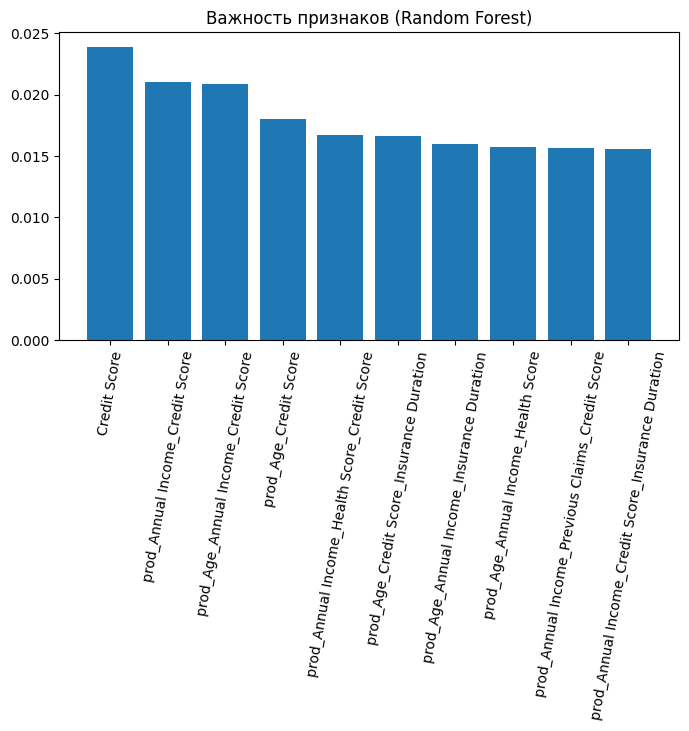

In [30]:
# Важность признаков
importances = rfr_fe.feature_importances_
feature_names = X_train_fe.columns

# Отсортируем по убыванию важности
feature_importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
).sort_values("Importance", ascending=False)

num_features = 10
feature_importance_df = feature_importance_df.head(num_features)

print(f"Таблица {num_features } наиболее важных признаков:")
print(feature_importance_df)

# График важности признаков
plt.figure(figsize=(8, 4))
plt.bar(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.xticks(rotation=80)
plt.title("Важность признаков (Random Forest)")
plt.show()

Наиболее важными являются признаки, связанные с кредитным рейтингом, доходом и возрастом заемщика.